In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

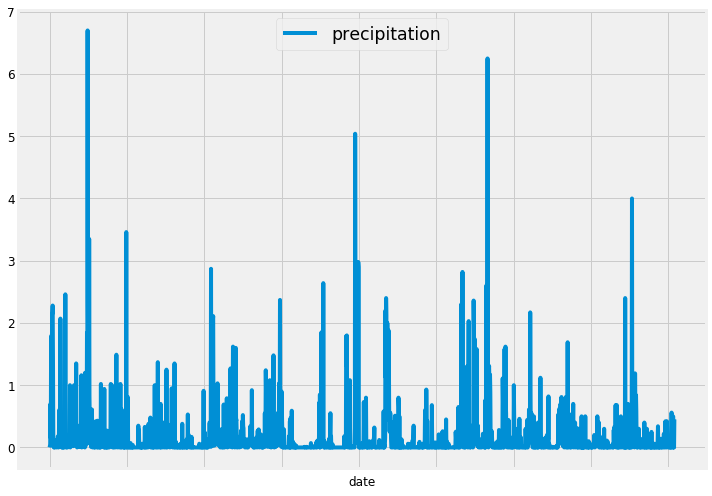

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the result
# Calculate the date 1 year ago from the last data point in the database                         
maxdate_qry = list(session.query(func.max(Measurement.date)))
maxdate_df = pd.read_sql(session.query(func.max(Measurement.date)).statement,session.bind)
maxdate = maxdate_df.iloc[0,0]
maxdate_year = int(maxdate[0:4])
maxdate_lastyr = str(maxdate_year-1)
lastyyyymmdd = maxdate.replace(str(maxdate_year),maxdate_lastyr)
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
#sql query with parameters delineated by '?'
sql = "SELECT Measurement.date, Measurement.prcp FROM Measurement WHERE date BETWEEN ? AND ? AND prcp NOT NULL"
prcp_df = pd.read_sql_query(sql, conn, params=(lastyyyymmdd,maxdate))
prcp_df = prcp_df.set_index('date').sort_values(by=['date'])
prcp_df = prcp_df.rename(index=str, columns={"prcp": "precipitation"})
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(10,7),legend=True, fontsize='large')
legend = plt.legend(loc='upper center',fontsize='xx-large')
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [79]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [81]:
# Design a query to show how many stations are available in this dataset?
station_df = pd.read_sql_query("select * from Station", conn)
station_count = station_df['station'].count()
print(f"There is data from {station_count} distinct stations in this dataset.")

There is data from 9 distinct stations in this dataset.


In [43]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sql1 = ("SELECT * FROM Measurement")
measurement_df = pd.read_sql_query(sql1, conn)
measurement_station = measurement_df.groupby(['station']).count()
active_stations = measurement_station.sort_values(by=['id'],ascending=False)
active_stations = active_stations.drop(['date','prcp','tobs'],axis=1)
active_stations.rename(index=str, columns={"id": "Observation Count"})
top_station = active_stations.index.values[0]
top_station

'USC00519281'

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station_tobs = pd.read_sql(session.query(Measurement).filter(Measurement.station==top_station).statement,session.bind)
lowest_temp = pd.read_sql(session.query(func.min(Measurement.tobs)).filter(Measurement.station==top_station).statement,session.bind)
highest_temp = pd.read_sql(session.query(func.max(Measurement.tobs)).filter(Measurement.station==top_station).statement,session.bind)
avg_temp = pd.read_sql(session.query(func.avg(Measurement.tobs)).filter(Measurement.station==top_station).statement,session.bind)

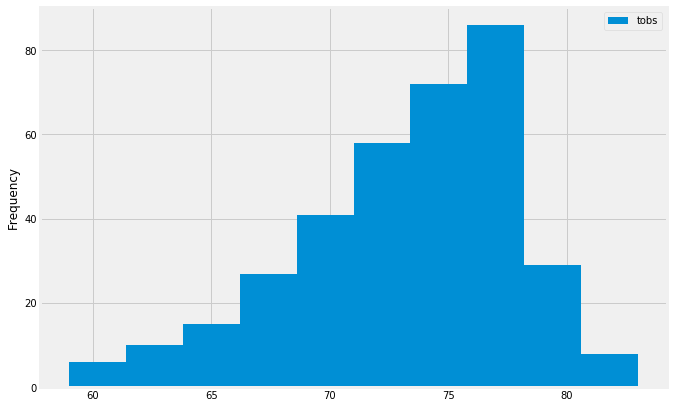

In [47]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sql_topstn = "SELECT Measurement.date, Measurement.tobs FROM Measurement WHERE date BETWEEN ? AND ? AND prcp NOT NULL AND station = ?"
topstn_df = pd.read_sql_query(sql_topstn, conn, params=(lastyyyymmdd,maxdate,top_station))
topstn_df.plot(kind="hist",figsize=(10,7))


![precipitation](Images/station-histogram.png)

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calctemp_output = calc_temps('2011-02-28', '2011-03-05')[0]
tavg = calctemp_output[1]
tmin = calctemp_output[0]
tmax = calctemp_output[2]
calctemp_output

(61.0, 69.75510204081633, 75.0)

Text(0,0.5,'Temp (F)')

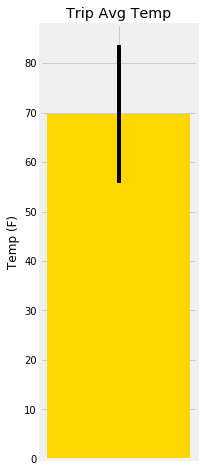

In [107]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2.5,8))
plt.bar(x='',height=tavg, width=0.1,yerr=tmax-tmin,color='gold')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")



In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


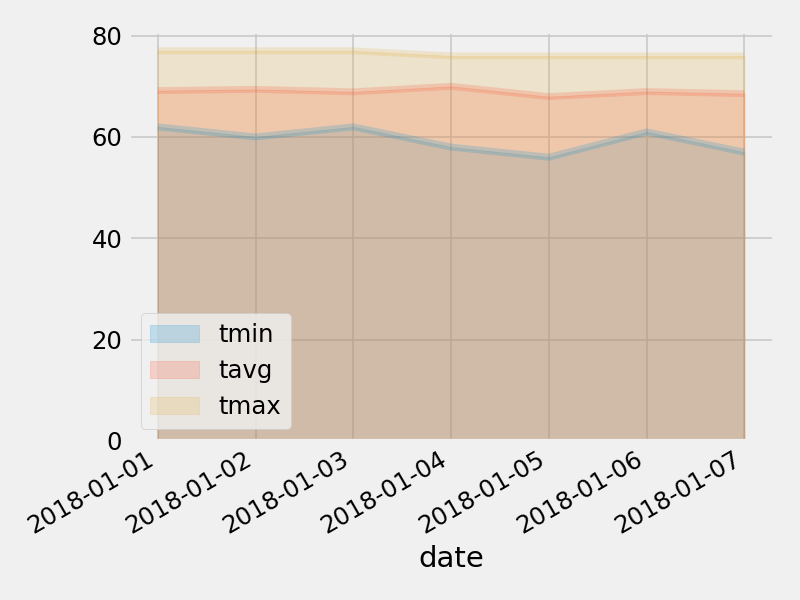

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
